# Creating videos tutorial

In [ ]:
import sys
sys.path.append('..')

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import deeptrack as dt
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
DP = datasets_phenom()

C:\Users\Gorka\anaconda3\lib\site-packages\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
C:\Users\Gorka\anaconda3\lib\site-packages\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


## 1. Single state diffusion

In [ ]:
T = 10 # number of time steps (frames)
N = 50 # number of particles (trajectories)
L = 1.5 * 128 # length of the box (pixels) -> exteneding fov by 1.5 times
D = 0.1 # diffusion coefficient (pixels^2/frame)

In [ ]:

trajs_model1, labels = models_phenom().single_state(N=N, L=L, T=T, Ds=D, alphas=0.5)

## 2. Multi state diffusion

In [ ]:
trajs_model2, labels_model2 = models_phenom().multi_state(
    N=N,
    L=L,
    T=T,
    alphas=[1.2, 0.7],
    Ds=[10 * D, 0.1 * D],
    M=np.array([[0.98, 0.02], [0.02, 0.98]]),
)

## 3. Dimerization

In [ ]:
trajs_model3, labels_model3 = models_phenom().dimerization(
    N=N,
    L=L,
    T=T,
    alphas=[1.2, 0.7],
    Ds=[10 * D, 0.1 * D],
    r=1,  # radius of the particles
    Pb=1,  # binding probability
    Pu=0,  # unbinding probability
)

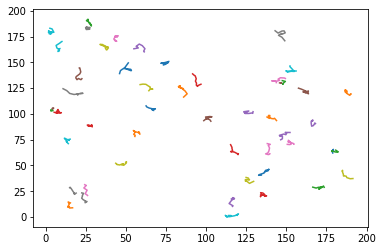

In [ ]:
t3 = np.moveaxis(trajs_model3, 0, 1)
for traj in t3:
    plt.plot(traj[:,0], traj[:,1])
plt.show()

## 4. Immobile traps

In [ ]:
number_traps = 100
traps_positions = np.random.rand(number_traps, 2)*L/2 

In [ ]:
trajs_model4, labels_model4 = models_phenom().immobile_traps(
    N=N,
    T=T,
    L=L,
    r=1,  # radius of the traps
    Pu=0.01,  # Unbinding probability
    Pb=1,  # Binding probability
    Ds=D,  # Diffusion coefficients of moving state
    alphas=1.6,  # Anomalous exponents of moving state
    Nt=number_traps,  # number of traps
    traps_pos=traps_positions,
)

## 5. Confinement

In [ ]:
number_compartments = 100
radius_compartments = 10
compartments_center = models_phenom._distribute_circular_compartments(
    Nc=number_compartments, r=radius_compartments, L=L  # size of the environment
)

In [ ]:
trajs_model5, labels_model5 = models_phenom().confinement(
    N=N,
    L=L,
    Ds=[1500 * D, 50 * D],
    comp_center=compartments_center,
    r=radius_compartments,
    trans=0.2,  # boundary transmittance
)

## 6.  Videos


For generating videos we import ``get_video_andi`` function from **andi_datasets** package

In [ ]:
from andi_datasets.utils_videos import transform_to_video, play_video

### 6.1. Generating videos
The trajectory data generated through ``models_phenom()`` can be directly passed through ``transform_to_video`` function to generate fluorescence images of the particles (and the particle masks). By default, ``transform_to_video`` will output just the videos. If the list ``get_vip_particles`` is non-empty, the masks of the vip particles in the first frame are appended to the first frame of the output. If the ``with_masks`` is set to ``True``, the function will output both the video and masks. In this case, the function can be called as ``video, masks = transform_to_video(...., with_masks=True)``.


The properites of the videos can be controlled by the dictionaries ``particle_props``, ``optics_props``, and ``background_props``. 

1. _particle_props_: The intensity of various particles in the final image can be controlled with ``particle_intensity``  by giving a mean intensity and standard deviation. The intensity variation of a single particle within multiple frames can be controlled by giving a standard deviation in ``intensity_variation``. Note that the intensity variation will be applied on the randomly sampled particle intensities from the first frame

2. _optics_props_: Most of the optics properties are fixed to match the experimental conditions. But they can still be modified accordingly. Please check the available properties for ``optics_props`` in **utils_videos.ipynb**

3. _background_props_: The mean background offset and the standard deviation of background within multiple frames can be controlled with ``background_mean`` and ``background_stdev``. A combination of ``particle_intensity`` and ``background_mean``can be used to tune the noise in the final image. For example., a low singal to noise ratio can be obtained by bringing the particle intensities closer to the background value

In [ ]:
origin = 0
width = 200
video, masks = transform_to_video(
    trajs_model1,

    particle_props={
        "particle_intensity": [100, 10],  # [mean, stdev]
        "intensity_variation": 0         # intensity variation
    },

    optics_props={
        "output_region": [origin, origin, width+origin,width+origin], # Default region is [0, 0, 128, 128]
    },

    background_props={
        "background_mean": 10,  # Mean background
        "background_stdev": 5   # Stdev background
    },

    with_masks=True
    
)

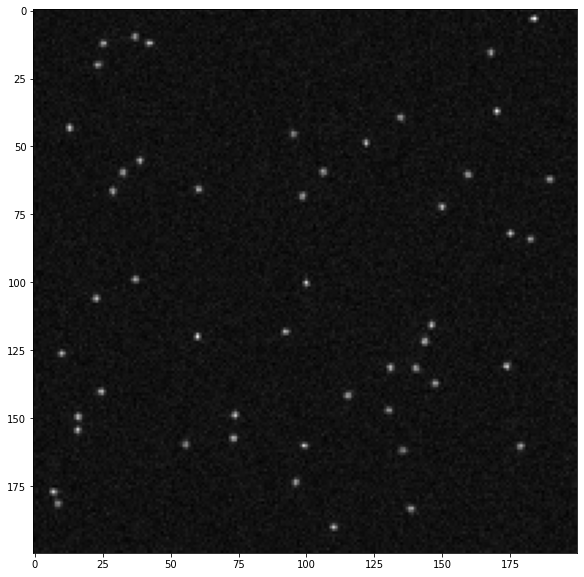

In [ ]:
from matplotlib.patches import Rectangle
plt.figure(figsize=(10,10))
plt.imshow(video[0], cmap="gray")
plt.show()

Text(0.5, 1.0, 'Mask')

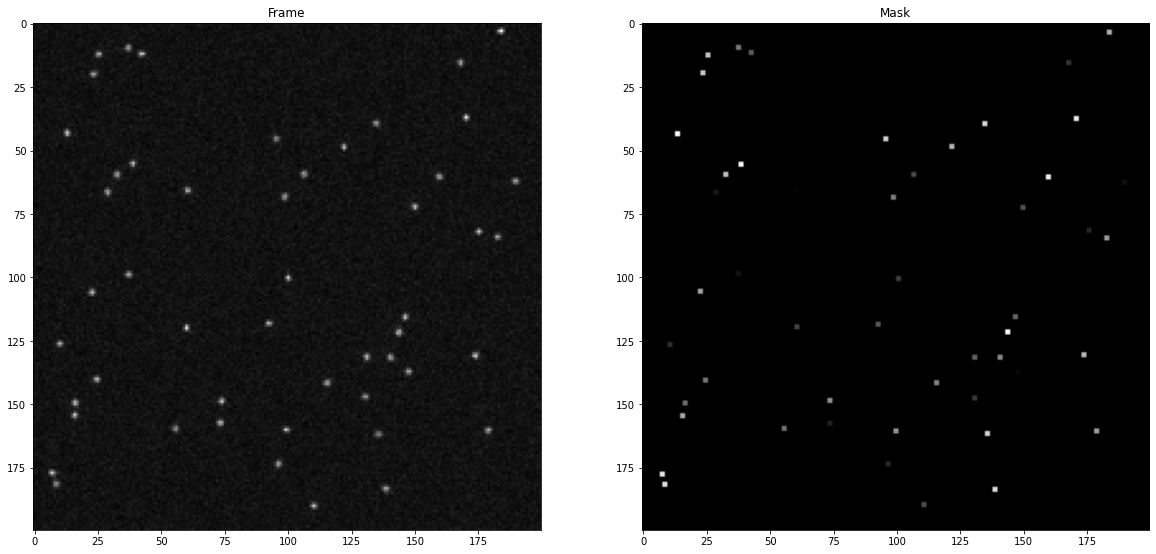

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
ax0.imshow(video[0], cmap="gray")
ax0.set_title("Frame")
ax1.imshow(masks[0], cmap="gray")
ax1.set_title("Mask")

### 6.2 Visualizing the paricles and masks in the first frame
Plotting the first frame of the video along with the particle mask

Overlaying the particle trajectories on the first frame of the video

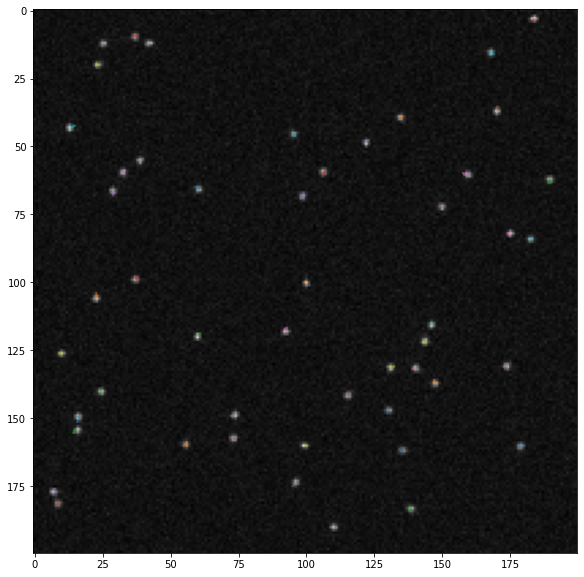

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(video[0], cmap="gray")
for traj in np.moveaxis(trajs_model1, 0, 1):
    plt.plot(traj[:,1], traj[:,0], alpha=0.5)
plt.show()

Visualzing the generated videos using ``play_video`` function

In [ ]:
play_video(video, figsize=(10, 10)) # can also be used with masks

### 6.2 Save the videos
Convert the video to 8bit and save it as an .MP4 file. Alternatively they can direclty be saved as numpy arrays with ``np.save(...)``

In [ ]:
def convert_uint8(vid):
    new_vid = []
    for im in vid:
        im = im[:,:,0]
        im = im / im.max()
        im = im * 255
        im = im.astype(np.uint8)
        new_vid.append(im)
    return new_vid

In [ ]:
video_frames_uint8

[array([[13, 18, 20, ..., 17,  9, 18],
        [ 4, 24, 12, ...,  9, 13, 12],
        [15, 13, 18, ..., 15, 13, 15],
        ...,
        [17, 10, 17, ..., 12, 23, 10],
        [20, 18, 20, ...,  7,  7, 20],
        [10, 15, 13, ..., 15, 10, 15]], dtype=uint8),
 array([[23, 16, 14, ..., 22, 17, 19],
        [13, 14, 25, ..., 11, 26, 19],
        [19, 14,  8, ..., 11, 14, 19],
        ...,
        [14, 16, 20, ..., 16, 22, 19],
        [16, 22, 17, ..., 17, 25, 37],
        [10, 20, 14, ..., 17, 11, 26]], dtype=uint8),
 array([[22, 24, 18, ..., 20, 19, 23],
        [23, 15, 16, ..., 18, 18, 15],
        [16, 11, 16, ..., 18, 11, 18],
        ...,
        [13, 15, 11, ..., 22, 23, 20],
        [16, 15, 23, ..., 15, 16, 19],
        [19, 18, 24, ..., 20, 15, 12]], dtype=uint8),
 array([[11, 12, 21, ..., 25, 12,  9],
        [ 9,  8,  5, ..., 14, 19,  7],
        [ 9, 12, 16, ..., 21, 22,  7],
        ...,
        [ 5,  9, 18, ..., 16, 15, 15],
        [21, 19, 11, ..., 12, 21, 12],
      

In [ ]:
# change the path accordingly
save_path = "phenom_model1.tiff"

In [ ]:
video_frames_uint8 = convert_uint8(video)
imageio.mimwrite(save_path, video_frames_uint8)

The following code will not work anymore - Needs to be deleted

# Figures videos

In [ ]:
from andi_datasets.datasets_phenom import datasets_phenom
DP = datasets_phenom()

datasets = []
for f in DP.avail_models_func:
    datasets = f(N = 500, T = 1, L = 300)[0]
    
    video = get_video_andi(datasets[0], optics_kwargs={"output_region": [origin, origin, 128+origin, 128+origin]})
    

In [ ]:
from andi_datasets.utils_videos import get_video_andi

In [ ]:
origin = 50 # pixels
video = get_video_andi(datasets[0], optics_kwargs={"output_region": [origin, origin, 128+origin, 128+origin]}) #change the output region to see the video

To store generated videos as a sequence of frames use ``update().resolve()``

In [ ]:
video_frames = video.update().resolve()

<matplotlib.image.AxesImage>

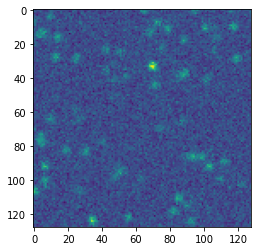

In [ ]:
plt.imshow(video_frames)

<matplotlib.image.AxesImage>

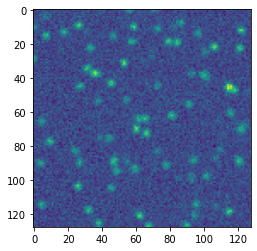

In [ ]:
plt.imshow(video_frames[0])

In [ ]:
vi